In [1]:
#import the goods
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pyart

import difflib
import os
import datetime
import time
import glob
import fnmatch
import matplotlib.colors as colors
from scipy import stats



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [2]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### EXAMPLE FOR A SINGLE PROFILE

#vel1q mean is the vr profile and z is the heights

radar = pyart.io.read(filename)
print (int(radar.nsweeps)) # get the number of sweeps, usually 6
swp = 0  #change this to get different sweeps (0-5)
elevs = radar.get_elevation(swp)
id_90 = (np.abs(elevs - 90)).argmin()
vel1q = radar.get_field(swp, 'VR_qc_reg5')[id_90-2:id_90+3, :] # this is +- 1 degreee
vel1q_mean = np.mean(vel1q, axis=0)
            
vals = np.array(radar.get_gate_x_y_z(swp)) #get the x, y, z coordinates
z = (vals[2,id_90,:])/1000 #get height in km

In [16]:
vel1_cone = []
vel1q_cone = []
vel1qc_cone = []
vel1_cone_all = []
vel1q_cone_all = []
vel1qc_cone_all = []
vel2_cone = []
vel2q_cone = []
vel2qc_cone = []

hid1_cone = []
hid1_cone_all = []
hid2_cone = []

dates = []
height = []
height_all = []

path = '/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/'

for path,dirs,files in sorted(os.walk(path)):
    for file in sorted(files):
        if fnmatch.fnmatch(file,'*'):
            fullname = os.path.join(path,file)
            radar = pyart.io.read(fullname)
            print (fullname)

            for swp in np.arange(0, int(radar.nsweeps), 1): #change the 1 to int(radar.nsweeps) to go thru all 6 sweeps of HSRHI
                new_rad = radar.extract_sweeps([swp])

                elevs = new_rad.get_elevation(0)
                id_90 = (np.abs(elevs - 90)).argmin()
                dbzs = new_rad.get_field(0, 'DZ_qc')[id_90-2:id_90+3, :]
                dbzs_mean = np.mean(dbzs, axis=0)

                vel1q = new_rad.get_field(0, 'VR_qc_reg5')[id_90-2:id_90+3, :] # this is +- 1 degreee
                vel1q_mean = np.mean(vel1q, axis=0)
                #print (np.shape(vel1_mean))
                #vel1q_cone.append(vel1_mean)

                vel1 = new_rad.get_field(0, 'VR_qc')[id_90-2:id_90+3, :] # this is +- 1 degreee
                vel1_mean = np.mean(vel1, axis=0)
                #print (np.shape(vel1_mean))
                #vel1_cone.append(vel1_mean)

                shp = (np.shape(new_rad.get_field(0, 'VR_qc'))[0])
                vr_mask = np.empty((int(shp), 1100))
                vr_mask[:] = -32768
                vr_mask[id_90-2:id_90+3,:] = vel1

                add_field_to_radar_object(vr_mask, new_rad, field_name='VR_mask', units='m/s', long_name='vr mask for +- 1cone',
                                                   standard_name='VR mask', dz_field='DZ_qc')

                gatefilter = pyart.correct.GateFilter(new_rad)
                gatefilter.exclude_invalid('VR_mask')

                velqc = pyart.correct.dealias_region_based(new_rad, vel_field='VR_qc', interval_splits=5, gatefilter=gatefilter)

                vel1qc = velqc['data'][id_90-2:id_90+3, :]
                vel1qc_mean = np.mean(vel1qc, axis=0)
                #vel1qc_cone.append(vel1qc_mean)
                
                hid1 = new_rad.get_field(0, 'HID_qc')[id_90-2:id_90+3, :]
                mode1 = stats.mode(hid1, axis=0)[0]
                #hid1_cone.append(mode1[0])
                #print (np.shape(mode1[0]))
                
                vals = np.array(new_rad.get_gate_x_y_z(0))
                z = (vals[2,id_90,:])/1000

                for x in np.arange(0, len(z), 1):
                    if dbzs_mean[x] > 0:
                        vel1_cone.append(vel1_mean[x])
                        vel1q_cone.append(vel1q_mean[x])
                        vel1qc_cone.append(vel1qc_mean[x])
                        hid1_cone.append(mode1[0][x])
                        height.append(z[x])
#                     else:
#                         vel1_cone.append(-100)
#                         vel1q_cone.append(-100)
#                         vel1qc_cone.append(-100)
#                         hid1_cone.append(0)

                for x in np.arange(0, len(z), 1):
                    if dbzs_mean[x] > 0:
                        vel1_cone_all.append(vel1_mean[x])
                        vel1q_cone_all.append(vel1q_mean[x])
                        vel1qc_cone_all.append(vel1qc_mean[x])
                        hid1_cone_all.append(mode1[0][x])
                        height_all.append(z[x])
                    else:
                        vel1_cone_all.append(-100)
                        vel1q_cone_all.append(-100)
                        vel1qc_cone_all.append(-100)
                        hid1_cone_all.append(0)
                        height_all.append(z[x])




#                 vel2 = new_rad.get_field(0, 'VR_qc_reg5')[id_90-4:id_90+5, :] # this is +- 2 degreee
#                 vel2_mean = np.mean(vel2, axis=0)
#                 vel2q_cone.append(vel2_mean)

#                 vel2 = new_rad.get_field(0, 'VR_qc')[id_90-4:id_90+5, :] # this is +- 2 degreee
#                 vel2_mean = np.mean(vel2, axis=0)
#                 vel2_cone.append(vel2_mean)

#                 shp = (np.shape(new_rad.get_field(0, 'VR_qc'))[0])
#                 vr_mask = np.empty((int(shp), 1100))
#                 vr_mask[:] = -32768
#                 vr_mask[id_90-4:id_90+5,:] = vel2

#                 add_field_to_radar_object(vr_mask, new_rad, field_name='VR_mask', units='m/s', long_name='vr mask for +- 1cone',
#                                                    standard_name='VR mask', dz_field='DZ_qc')

#                 gatefilter = pyart.correct.GateFilter(new_rad)
#                 gatefilter.exclude_invalid('VR_mask')

#                 velqc = pyart.correct.dealias_region_based(new_rad, vel_field='VR_qc', interval_splits=5, gatefilter=gatefilter)

#                 vel2qc = velqc['data'][id_90-4:id_90+5, :]
#                 vel2qc_mean = np.mean(vel2qc, axis=0)
#                 vel2qc_cone.append(vel2qc_mean)



#                 #hid1_mean = np.mean(hid1, axis=0)
#                 #hid1_cone.append(hid1_mean)

#                 hid2 = new_rad.get_field(0, 'HID_qc')[id_90-4:id_90+5, :]
#                 mode2 = stats.mode(hid2, axis=0)[0]
#                 hid2_cone.append(mode2[0])

#                 #hid2_mean = np.mean(hid2, axis=0)
#                 #hid2_cone.append(hid2_mean)

                date = str(pyart.util.datetime_from_radar(new_rad))
                conv_date = datetime.datetime.strptime(date[0:19],'%Y-%m-%d %H:%M:%S')
                conv2 = conv_date.strftime("%Y%m%d_%H%M%S")

                dates.append(conv2)




/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.192234.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.192620.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.193714.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.194100.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.195214.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.195600.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.200714.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.201100.csuqc.nc
/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec5/corcsapr2cfrhsrhiqcM1.b1.20181205.202214.csuqc.nc
/rasmussen-scratch2/mrocque/

In [17]:
vel1_cone1 = 1 * np.array(vel1_cone)
vel1_cone1[vel1_cone1 < -100] = np.nan

vel1q_cone1 = 1 * np.array(vel1q_cone)
vel1q_cone1[vel1q_cone1 < -100] = np.nan

vel1qc_cone1 = 1 * np.array(vel1qc_cone)
vel1qc_cone1[vel1qc_cone1 < -100] = np.nan

vel2_cone1 = 1 * np.array(vel2_cone)
vel2_cone1[vel2_cone1 < -100] = np.nan

vel2q_cone1 = 1 * np.array(vel2q_cone)
vel2q_cone1[vel2q_cone1 < -100] = np.nan

vel2qc_cone1 = 1 * np.array(vel2qc_cone)
vel2qc_cone1[vel2qc_cone1 < -100] = np.nan

hid1_cone1 = 1 * np.array(hid1_cone, dtype=float)
hid1_cone1[hid1_cone1 < 0] = np.nan

hid2_cone1 = 1 * np.array(hid2_cone, dtype=float)
hid2_cone1[hid2_cone1 < 0] = np.nan


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:17: DeprecationWarning: invalid escape sequence \p
<>:17: DeprecationWarning: invalid escape sequence \p
<ipython-input-18-aac9677b4de9>:17: DeprecationWarning: invalid escape sequence \p
  plt.title('Distribution of Vertical Motions from all HSRHIs\n(uncorrected, folded, $\pm$1$^{\circ}$ cone, dBZ>0)', fontsize=14)


Text(-68, 0.1, 'min = -12.54')

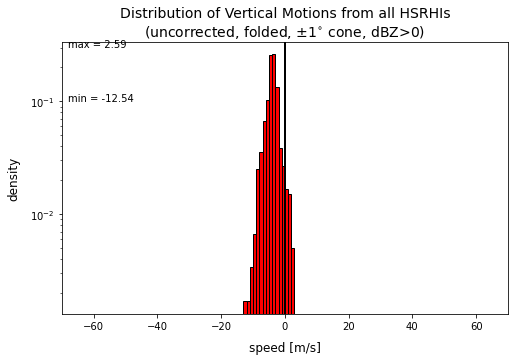

In [18]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')

b = np.arange(-68, 68.5, 1)
weights = np.ones_like(vel1qc_cone1) / len(vel1qc_cone1)

ax = plt.subplot(111)

plt.hist(vel1qc_cone1, bins=b, color='r', edgecolor='k', weights=weights, alpha=1)


plt.xlim(-70, 70)
plt.xlabel('speed [m/s]', labelpad=10, fontsize=12)
plt.ylabel('density', labelpad=10, fontsize=12)

plt.axvline(0, 0, 1, color='k', lw=2)
plt.title('Distribution of Vertical Motions from all HSRHIs\n(uncorrected, folded, $\pm$1$^{\circ}$ cone, dBZ>0)', fontsize=14)
plt.yscale('log')
#plt.ylim(1e-9, 1e0)

plt.text(-68, 3e-1, 'max = '+str(np.round(np.nanmax(vel1qc_cone1), 2)))
plt.text(-68, 1e-1, 'min = '+str(np.round(np.nanmin(vel1qc_cone1), 2)))

#plt.savefig('hsrhi_vertmotion_uncorr_all_log_wrfmatch.png', dpi=400, bbox_inches='tight')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.02, 'CFAD Vertical Motion from WRF\n20181205_1500 $-$ 20181206_0000 UTC')

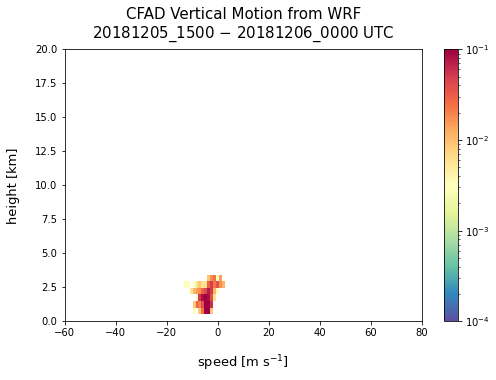

In [19]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')
import matplotlib
my_cmap = matplotlib.cm.get_cmap("Spectral_r").copy()
my_cmap.set_under('w')

ax = plt.subplot(111)

pl1 = plt.hist2d(vel1qc_cone1, height, (120,44), [[-60, 80], [0.5, 22]], density=True, cmap=my_cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
plt.colorbar(extend='neither')
plt.xlim(-60, 80)
plt.ylim(0, 20)
plt.xlabel('speed [m s$^{-1}$]', labelpad=15, fontsize=13)
plt.ylabel('height [km]', labelpad=15, fontsize=13)

plt.title('CFAD Vertical Motion from WRF\n20181205_1500 $-$ 20181206_0000 UTC', y=1.02, fontsize=15)

#plt.savefig('wrf1km_cfad_vertmotion_alltemps_alldom_20181205.png', dpi=400, bbox_inches='tight')

In [7]:
np.savetxt('./dec14_csapr2_hsrhi_corrected_cone1.txt', np.array(vel1qc_cone1))#, fmt='%s')
np.savetxt('./dec14_csapr2_hsrhi_heights_cone1.txt', np.array(height))#, fmt='%s')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
np.savetxt('./jan25_csapr2_hsrhi_corrected_cone1.txt', np.array(vel1qc_cone1))#, fmt='%s')
np.savetxt('./jan25_csapr2_hsrhi_heights_cone1.txt', np.array(height))#, fmt='%s')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
np.savetxt('./dec5_csapr2_hsrhi_corrected_cone1.txt', np.array(vel1qc_cone1))#, fmt='%s')
np.savetxt('./dec5_csapr2_hsrhi_heights_cone1.txt', np.array(height))#, fmt='%s')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
dec14_vr = np.loadtxt('./dec14_csapr2_hsrhi_corrected_cone1.txt')
jan25_vr = np.loadtxt('./jan25_csapr2_hsrhi_corrected_cone1.txt')
dec5_vr = np.loadtxt('./dec5_csapr2_hsrhi_corrected_cone1.txt')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
print (np.min(dec5_vr))
print (np.max(dec5_vr))
print (np.min(dec14_vr))
print (np.max(dec14_vr))
print (np.min(jan25_vr))
print (np.max(jan25_vr))

-12.53778533935547
2.589536666870117
-22.294273376464844
7.590336608886719
-24.205648803710936
12.91124267578125


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:22: DeprecationWarning: invalid escape sequence \p
<>:22: DeprecationWarning: invalid escape sequence \p
<ipython-input-30-ae4e8a445189>:22: DeprecationWarning: invalid escape sequence \p
  plt.title('Distribution of Vertical Motions from HSRHIs\n(uncorrected, dealiased, $\pm$1$^{\circ}$ cone, dBZ>0)', fontsize=14)


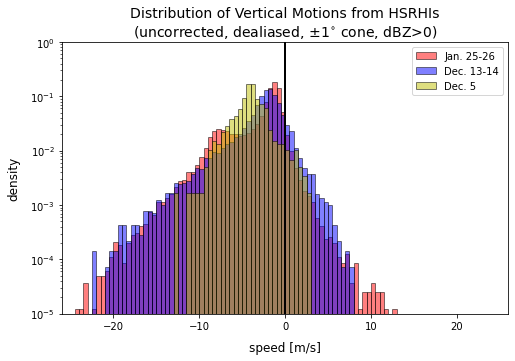

In [30]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')
b = np.arange(-25, 25.5, 0.5)


ax = plt.subplot(111)

weights = np.ones_like(jan25_vr) / len(jan25_vr)
plt.hist(jan25_vr, bins=b, color='r', edgecolor='k', weights=weights, alpha=0.5, label='Jan. 25-26')

weights = np.ones_like(dec14_vr) / len(dec14_vr)
plt.hist(dec14_vr, bins=b, color='b', edgecolor='k', weights=weights, alpha=0.5, label='Dec. 13-14')

weights = np.ones_like(dec5_vr) / len(dec5_vr)
plt.hist(dec5_vr, bins=b, color='y', edgecolor='k', weights=weights, alpha=0.5, label='Dec. 5')

plt.xlim(-26, 26)
plt.xlabel('speed [m/s]', labelpad=10, fontsize=12)
plt.ylabel('density', labelpad=10, fontsize=12)

plt.axvline(0, 0, 1, color='k', lw=2)
plt.title('Distribution of Vertical Motions from HSRHIs\n(uncorrected, dealiased, $\pm$1$^{\circ}$ cone, dBZ>0)', fontsize=14)
plt.yscale('log')
plt.ylim(1e-5, 1e0)

plt.legend()

#plt.text(-68, 3e-1, 'max = '+str(np.round(np.nanmax(vel1qc_cone1), 2)))
#plt.text(-68, 1e-1, 'min = '+str(np.round(np.nanmin(vel1qc_cone1), 2)))

#plt.savefig('hsrhi_vertmotion_uncorr_dealiased_cases_log.png', dpi=400, bbox_inches='tight')

In [31]:
hgt5 = np.loadtxt('./dec5_csapr2_hsrhi_heights_cone1.txt')
hgt14 = np.loadtxt('./dec14_csapr2_hsrhi_heights_cone1.txt')
hgt25 = np.loadtxt('./jan25_csapr2_hsrhi_heights_cone1.txt')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


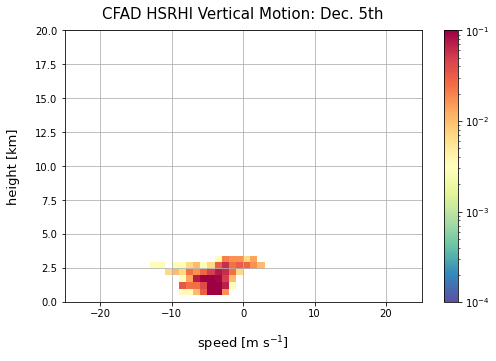

In [42]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')
import matplotlib
my_cmap = matplotlib.cm.get_cmap("Spectral_r").copy()
my_cmap.set_under('w')

ax = plt.subplot(111)

pl1 = plt.hist2d(dec5_vr, hgt5, (50,44), [[-25, 25], [0.5, 22]], density=True, cmap=my_cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
plt.colorbar(extend='neither')
plt.xlim(-25, 25)
plt.ylim(0, 20)
plt.xlabel('speed [m s$^{-1}$]', labelpad=15, fontsize=13)
plt.ylabel('height [km]', labelpad=15, fontsize=13)

plt.title('CFAD HSRHI Vertical Motion: Dec. 5th', y=1.02, fontsize=15)
plt.grid()

#plt.savefig('cfad_hsrhi_vertmotion_uncor_dealias_dec5.png', dpi=400, bbox_inches='tight')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


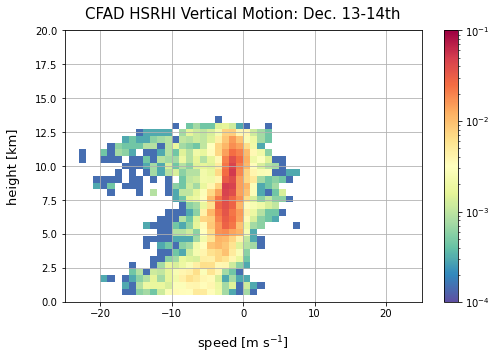

In [44]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')
import matplotlib
my_cmap = matplotlib.cm.get_cmap("Spectral_r").copy()
my_cmap.set_under('w')

ax = plt.subplot(111)

pl1 = plt.hist2d(dec14_vr, hgt14, (50,44), [[-25, 25], [0.5, 22]], density=True, cmap=my_cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
plt.colorbar(extend='neither')
plt.xlim(-25, 25)
plt.ylim(0, 20)
plt.xlabel('speed [m s$^{-1}$]', labelpad=15, fontsize=13)
plt.ylabel('height [km]', labelpad=15, fontsize=13)

plt.title('CFAD HSRHI Vertical Motion: Dec. 13-14th', y=1.02, fontsize=15)
plt.grid()

#plt.savefig('cfad_hsrhi_vertmotion_uncor_dealias_dec14.png', dpi=400, bbox_inches='tight')

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


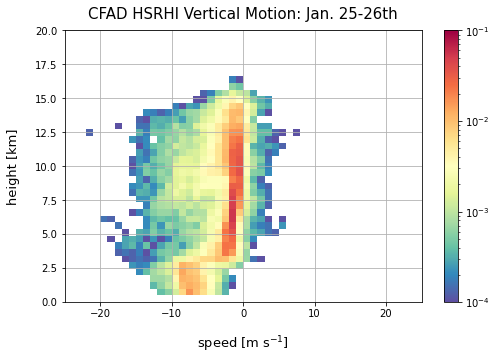

In [46]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')
import matplotlib
my_cmap = matplotlib.cm.get_cmap("Spectral_r").copy()
my_cmap.set_under('w')

ax = plt.subplot(111)

pl1 = plt.hist2d(jan25_vr, hgt25, (50,44), [[-25, 25], [0.5, 22]], density=True, cmap=my_cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
plt.colorbar(extend='neither')
plt.xlim(-25, 25)
plt.ylim(0, 20)
plt.xlabel('speed [m s$^{-1}$]', labelpad=15, fontsize=13)
plt.ylabel('height [km]', labelpad=15, fontsize=13)

plt.title('CFAD HSRHI Vertical Motion: Jan. 25-26th', y=1.02, fontsize=15)
plt.grid()

#plt.savefig('cfad_hsrhi_vertmotion_uncor_dealias_jan25.png', dpi=400, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('xkcd:white')

b = np.arange(1, 11, 1)
weights = np.ones_like(hid1_cone1) / len(hid1_cone1)

ax = plt.subplot(111)

plt.hist(hid1_cone1, bins=b, color='r', edgecolor='k', weights=weights, alpha=1)


plt.xlim(0, 10)
plt.xlabel('speed [m/s]', labelpad=10, fontsize=12)
plt.ylabel('density', labelpad=10, fontsize=12)

plt.axvline(0, 0, 1, color='k', lw=2)
plt.title('Distribution of Vertical Motions from all HSRHIs\n(uncorrected, folded, $\pm$1$^{\circ}$ cone, dBZ>0)', fontsize=14)
plt.yscale('log')
#plt.ylim(1e-9, 1e0)

plt.text(-1, 3e-1, 'max = '+str(np.round(np.nanmax(hid1_cone1), 2)))
plt.text(-1, 1e-1, 'min = '+str(np.round(np.nanmin(hid1_cone1), 2)))

#plt.savefig('hsrhi_vertmotion_uncorr_all_log_wrfmatch.png', dpi=400, bbox_inches='tight')

In [ ]:
print (np.shape(vel1qc_cone_all))
print (np.shape(height_all))
print (np.shape(dates))
print (np.shape(hid1_cone_all))

In [ ]:
new_velqc = np.reshape(vel1qc_cone_all, (576, 1100))
new_hid1 = np.reshape(hid1_cone_all, (576, 1100))

In [ ]:
print (np.shape(new_velqc))

In [ ]:
plt.pcolormesh(new_hid1.T, vmin=0, vmax=10)
plt.ylim(0, 200)

In [ ]:
plt.pcolormesh(new_velqc.T)
plt.ylim(0, 200)

In [ ]:
# plt.plot(vel1qc_cone)
plt.ylim(-20, 20)

In [ ]:
vel1_cone2 = np.ndarray.flatten(vel1_cone1)
vel1q_cone2 = np.ndarray.flatten(vel1q_cone1)
vel1qc_cone2 = np.ndarray.flatten(vel1qc_cone1)
vel2_cone2 = np.ndarray.flatten(vel2_cone1)
vel2q_cone2 = np.ndarray.flatten(vel2q_cone1)
vel2qc_cone2 = np.ndarray.flatten(vel2qc_cone1)

hid1_cone2 = np.ndarray.flatten(hid1_cone1)
hid2_cone2 = np.ndarray.flatten(hid2_cone2)

In [ ]:
# #get the velocity and HID from each file at 90deg (vertical)
# path = '/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec14/'
# vel1_cone = []
# vel1q_cone = []
# vel2_cone = []
# vel2q_cone = []

# hid1_cone = []
# hid2_cone = []

# dates = []

# for path,dirs,files in sorted(os.walk(path)):
#     for file in sorted(files):
#         if fnmatch.fnmatch(file,'*'):
#             f = os.path.join(path,file)
#             print (f)
#             radar = pyart.io.read(f)

#             for swp in np.arange(0, int(radar.nsweeps), 1): #change the 1 to int(radar.nsweeps) to go thru all 6 sweeps of HSRHI
#                 new_rad = radar.extract_sweeps([swp])
                
#                 elevs = new_rad.get_elevation(0)
#                 id_90 = (np.abs(elevs - 90)).argmin()
                
#                 vel1 = new_rad.get_field(0, 'VR_qc_reg5')[id_90-2:id_90+3, :] # this is +- 1 degreee
#                 vel1_mean = np.mean(vel1, axis=0)
#                 vel1q_cone.append(vel1_mean)
                
#                 vel1 = new_rad.get_field(0, 'VR_qc')[id_90-2:id_90+3, :] # this is +- 1 degreee
#                 vel1_mean = np.mean(vel1, axis=0)
#                 vel1_cone.append(vel1_mean)
                
#                 vel2 = new_rad.get_field(0, 'VR_qc_reg5')[id_90-4:id_90+5, :] # this is +- 2 degreee
#                 vel2_mean = np.mean(vel2, axis=0)
#                 vel2q_cone.append(vel2_mean)
                
#                 vel2 = new_rad.get_field(0, 'VR_qc')[id_90-4:id_90+5, :] # this is +- 2 degreee
#                 vel2_mean = np.mean(vel2, axis=0)
#                 vel2_cone.append(vel2_mean)
                
#                 hid1 = new_rad.get_field(0, 'HID_qc')[id_90-2:id_90+3, :]
#                 hid1_mean = np.mean(hid1, axis=0)
#                 hid1_cone.append(hid1_mean)
                
#                 hid2 = new_rad.get_field(0, 'HID_qc')[id_90-4:id_90+5, :]
#                 hid2_mean = np.mean(hid2, axis=0)
#                 hid2_cone.append(hid2_mean)

#                 date = str(pyart.util.datetime_from_radar(new_rad))
#                 conv_date = datetime.datetime.strptime(date[0:19],'%Y-%m-%d %H:%M:%S')
#                 conv2 = conv_date.strftime("%Y%m%d_%H%M%S")

#                 dates.append(conv2)

In [ ]:
vals = np.array(new_rad.get_gate_x_y_z(0)) 
z = (vals[2,id_90,:])/1000 

In [ ]:
print (np.shape(dates))
print (np.shape(vel1_cone))
print (np.shape(z))

In [ ]:
t = np.arange(0, len(dates), 1)

meshz, mesht = np.array(np.meshgrid(z, t))  #create a meshgrid for z and t to read into pcolormesh/contourf
print (type(mesht))

In [ ]:
print (np.max(vel1_cone))
print (np.min(vel2_cone))

In [ ]:
print (dates[:][-6:-2])

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.patch.set_facecolor('xkcd:white')

plt.pcolormesh(mesht, meshz, vel1_cone, cmap='seismic', vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label('m/s')

t1 = np.arange(0, len(t)+1, 48)
plt.xticks(ticks=t1, labels=['20', '21', '22', '23','00', '01', '02', '03', '04', '05', '06', '07', '08'])

plt.ylim(0, 16)
plt.ylabel('height (km)', fontsize=12, labelpad=15)
plt.xlabel('time (UTC)', fontsize=12, labelpad=15)
plt.xlim(144, 480)

plt.title(r'w (folded, uncorrected) from $\pm$1$^{\circ}$ cone', fontsize=14)

#plt.savefig('dec14_hsrhi_w_cone1_uncor.png', dpi=400, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.patch.set_facecolor('xkcd:white')

plt.pcolormesh(mesht, meshz, vel2_cone, cmap='seismic', vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label('m/s')

t1 = np.arange(0, len(t)+1, 48)
plt.xticks(ticks=t1, labels=['20', '21', '22', '23','00', '01', '02', '03', '04', '05', '06', '07', '08'])

plt.ylim(0, 16)
plt.ylabel('height (km)', fontsize=12, labelpad=15)
plt.xlabel('time (UTC)', fontsize=12, labelpad=15)
plt.xlim(144, 480)

plt.title(r'w (folded, uncorrected) from $\pm$2$^{\circ}$ cone', fontsize=14)

#plt.savefig('dec14_hsrhi_w_cone2_uncor.png', dpi=400, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.patch.set_facecolor('xkcd:white')

plt.pcolormesh(mesht, meshz, vel1q_cone, cmap='seismic', vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label('m/s')

t1 = np.arange(0, len(t)+1, 48)
plt.xticks(ticks=t1, labels=['20', '21', '22', '23','00', '01', '02', '03', '04', '05', '06', '07', '08'])

plt.ylim(0, 16)
plt.ylabel('height (km)', fontsize=12, labelpad=15)
plt.xlabel('time (UTC)', fontsize=12, labelpad=15)
plt.xlim(144, 480)

plt.title(r'w (unfolded, uncorrected) from $\pm$1$^{\circ}$ cone', fontsize=14)

#plt.savefig('dec14_hsrhi_w_cone1.png', dpi=400, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.patch.set_facecolor('xkcd:white')

plt.pcolormesh(mesht, meshz, vel2q_cone, cmap='seismic', vmin=-15, vmax=15)
cbar = plt.colorbar()
cbar.set_label('m/s')

t1 = np.arange(0, len(t)+1, 48)
plt.xticks(ticks=t1, labels=['20', '21', '22', '23','00', '01', '02', '03', '04', '05', '06', '07', '08'])

plt.ylim(0, 16)
plt.ylabel('height (km)', fontsize=12, labelpad=15)
plt.xlabel('time (UTC)', fontsize=12, labelpad=15)
plt.xlim(144, 480)

plt.title(r'w (unfolded, uncorrected) from $\pm$2$^{\circ}$ cone', fontsize=14)

#plt.savefig('dec14_hsrhi_w_cone2.png', dpi=400, bbox_inches='tight')

In [ ]:
def two_panel_plot_csrhi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=70,
                   cmap1='pyart_HomeyerRainbow', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='ms-1', return_flag=True,
                   xlim=[-5,5], ylim=[0,20]):
    
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(18,5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=False, title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=False, title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    #plt.savefig('csapr2_20181214_0237_hsrhi30_regvel_10ints.png', dpi=400, bbox_inches='tight')
    
    if return_flag:
        return fig, ax1, ax2, display

In [ ]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [ ]:
#path = '/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec14/corcsapr2cfrhsrhiqcM1.b1.20181214.050715.csuqc.nc'
#path = '/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec14/corcsapr2cfrhsrhiqcM1.b1.20181214.011100.csuqc.nc'
path = '/rasmussen-scratch2/mrocque/research/relampago/hsrhi_dec14/corcsapr2cfrhsrhiqcM1.b1.20181214.020715.csuqc.nc'
radar = pyart.io.read(path)

elevs = radar.get_elevation(3)
id_90 = (np.abs(elevs - 90)).argmin()

In [ ]:
new_rad = radar.extract_sweeps([3])

vr = new_rad.get_field(0, 'VR_qc')[id_90-2:id_90+3, :]
#vr_mask = radar.get_field(0, 'VR_qc')[:,:]

print (np.shape(vr))
print (np.shape(new_rad.get_field(0, 'VR_qc'))[0])

In [ ]:
vr_mask = np.empty((np.shape(new_rad.get_field(0, 'VR_qc'))[0], 1100))
vr_mask[:] = -32768
vr_mask[id_90-2:id_90+3,:] = vr

add_field_to_radar_object(vr_mask, new_rad, field_name='VR_mask', units='m/s', long_name='vr mask for +- 1cone',
                                   standard_name='VR mask', dz_field='DZ_qc')


In [ ]:
gatefilter = pyart.correct.GateFilter(new_rad)
gatefilter.exclude_invalid('VR_mask')

In [ ]:
velqc = pyart.correct.dealias_region_based(new_rad, vel_field='VR_qc', interval_splits=5, gatefilter=gatefilter)#, nyquist_vel=26.65)

In [ ]:
print (np.shape(velqc['data']))

In [ ]:
field_dict = {'data':velqc['data'],'units':'ms-1', 'long_name':'velocity region-based5',
              'standard_name':'Velocity (QCed + reg5)', 
              '_FillValue':'-32768'}

new_rad.add_field('VR_qc2_reg5', field_dict, replace_existing=True)

In [ ]:
fig = two_panel_plot_csrhi(new_rad, 0, var1='VR_qc_reg5', vmin1=-20, vmax1=20, cmap1='seismic', var2='VR_qc2_reg5', vmin2=-20, 
               vmax2=20, cmap2='seismic')

#plt.savefig('bad_vrqc_20181214_0111_swp3_50km.png', dpi=400, bbox_inches='tight')

In [ ]:
hid = radar.get_field(0, 'HID_qc')[id_90-4:id_90+5, :]

In [ ]:
from scipy import stats

mode = stats.mode(hid, axis=0)[0]


In [ ]:
print (mode[0])

In [ ]:
plt.plot(mode[0])
plt.ylim(0, 10)

In [ ]:
plt.plot(mode[0])
plt.ylim(0, 10)